# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [2]:
import os
import spacy
import unidecode
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2024-08-01 13:58:34.053273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 13:58:35.191024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-01 13:58:35.191158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-01 13:58:35.191167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Data and sources


## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [3]:
liedjesDF = pd.read_csv("../data/liedjes.csv", dtype={'jaartal': 'Int32'})
liedjesDF = liedjesDF.sort_values(by=['songID'])

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    771
Number of booklets:  64


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [4]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(" ".join(new_text)) # add text to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords: list 
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfTexts, replaceDict, removeList):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.lower().split()
        preprocessedLiedje = remove(replace(liedje, replaceDict), removeList)
        result.append(" ".join(preprocessedLiedje))

    return result

We use the above functions to read the lyrics.

In [5]:
liedjesFilenames    = getlistOfFilenames('../data/lyrics')
liedjes             = getlistOfTexts(liedjesFilenames)
lemmatizedLiedjes   = lemmatize(liedjes, select = False)

# replaceDict = {"koster":"coster", "kosters":"costers", "vreugd":"vreugde", "blijd":"blijde"}
# removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "weer", "uw", 
#                "waarmee", "immer", "t", "d", "wijze", "hurah", "o"]

replaceDict = {}
removeList  = [] 

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList)

To investigate whether our code has worked, we look at the data of song with number ```n```.

In [6]:
n = 106

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- path: --")
print(liedjesFilenames[n])
print("-- song: --")
print(liedjes[n])
print("-- lemmatized song: --")
print(lemmatizedLiedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                             amsterdam1849
sourceID                         amsterdam1849-feestliederen1863
songID                        amsterdam1849-feestliederen1863-04
titel                   Hulde en dank aan het werkend gezelschap
wijze                                     Marchand de parapluies
jaartal                                                     1863
schrijver                                        R. van der Star
vereniging_schrijver                               amsterdam1849
Name: 170, dtype: object
-- path: --
../data/lyrics/amsterdam1849/amsterdam1849-feestliederen1863/amsterdam1849-feestliederen1863-04.txt
-- song: --
Hulde en dank aan het werkend gezelschap

Wij vieren thans weder ons jaarlijksche Feest
En doen het als altijd met vrolijken geest.
In vroegeren dagen ,
Kon ’t zoo niet behagen, |
Zoo als het nu heden toch gaat.
Gij Werkende Kring,
Blijft zoo onderling,
Voor Voorzorgs Genoegen steeds waken.
Blijft zoo op den duur,
Met

# Handmade topics
I study the topics in my songs by creating handmade topics of terms that I think represent a certain topic. How much is nationalism represented in the songs? Or professional pride? This can be studied by calculating how relatively often the hand-picked terms are used in the songs. Therefor I create a document-term-matrix and vectors for every handmade topic.


In [7]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

def listify(listOfTexts):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.split()
        result.append(liedje)

    return result

def topics2vectors(topicList, vocabulary):
    result = []
    for topic in topicList:
        topicVector = []
        for term in vocabulary:
            if term in topic:
                topicVector.append(1)
            else:
                topicVector.append(0)
        result.append(topicVector)

    return result


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
dtmLiedjes = np.array(vectorizer.fit_transform(liedjes).todense())

vocabulary = vectorizer.vocabulary_
liedjesVocabulary = sorted(vocabulary.keys(), key=lambda word: vocabulary[word])


## Topics
In the following block the hand made topics, with hand picked terms are created. 

## Calculating cosine similarity
The following block calculates the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the handmade topic vector and the documentvector per song. After that I calculate the mean cosine similarity of all the songs per year.

In [9]:
def createSimilarities(topicVectors, liedjesDF):
    for j in range(len(topicVectors)):
        topic = "topic" + str(j)
        b = topicVectors[j]
        similarities = []
        for i in range(len(liedjesDF)):
            a = dtmLiedjes[i]
            if np.linalg.norm(a) > 0:
                cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            else:
                cos_sim = 0.0
            similarities.append(cos_sim)
        liedjesDF[topic] = similarities

    return liedjesDF.groupby('jaartal').mean(numeric_only=True).rolling(1).mean(numeric_only=True)


In [10]:
topic0 = ['nederland',  'holland',  'nederlandsch', 'nederlandsche', 'nederlandschen', 'hollandsch', 'hollandsche', 'hollandschen', 'nederlands', 'nederlandse', 'nederlandsen', 'hollands', 'hollandse', 'hollandsen', 'neerlands', 'neerlandse', 'neerlandsen', 'geboortegrond',  'geboorteland',  'moederland',  'patria', 'vaderland', 'held', 'landgenoot']
topic1 = ['koning', 'vorst', 'willem', 'oranje', 'koninklijk', 'nassau']
topic2 = ['eereleden', 'beschermheer', 'donateurs', 'baas', 'patroon', 'patronen', 'burgervader', 'heeren', 'honorair', 'hooggeachte']
topic3 = ['laurens', 'lourens', 'coster', 'costers', 'koster', 'kosters', 'standbeeld', 'metalen', 'haarlem', 'spaarnestad', 'spaarne', 'haarlemmerhout']
topic4 = ['eendragt', 'verbinden', 'zaam', 'samen', 'band', 'kring', 'zorg', 'broeder', 'trouw', 'hulp', 'vriendenkring']
topic5 = ['kunst', 'boekdrukkunst', 'drukkunst', 'schoon', 'schoonheid', 'schoone']
topic6 = ['verlichting', 'licht', 'verlichten', 'vrijheid', 'vrij', 'bevrijden', 'wetenschap', 'waarde', 'nut', 'nuttig', 'verheffen', 'beschaving', 'beschaven', 'maatschappij', 'samenleving', 'kennis', 'wijsheid', 'wijs']
topic7 = ['roem', 'roemen', 'eer', 'glorie', 'trots', 'trotsch', 'triomf', 'edel', 'eedle', 'edele', 'eere', 'fier', 'lof']
topic8 = ['loon', 'prijzen']
topic9 = ['zegelwet', 'belasting']

topicList = [topic0, topic1, topic2, topic3, topic4, topic5, topic6, topic7]
topicVectors = np.array(topics2vectors(topicList, liedjesVocabulary))

df = createSimilarities(topicVectors, liedjesDF)

Text(0.5, 0, 'year')

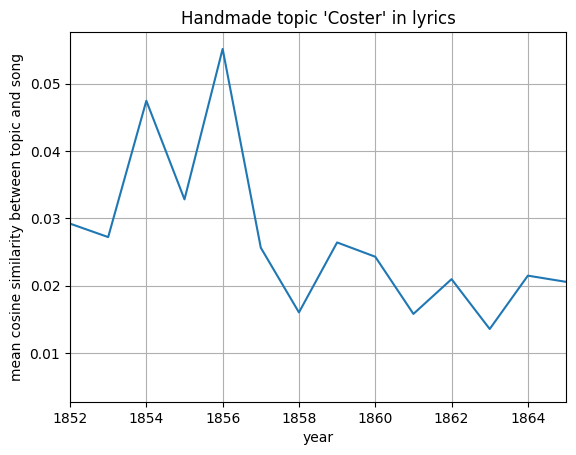

In [11]:
# Change of Coster topic
ax = df['topic3'].plot(title="Handmade topic 'Coster' in lyrics", xlim=(1852,1865), grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
# ax.legend(['topic vaderland', 'topic koninklijk huis', 'topic laurens coster'])


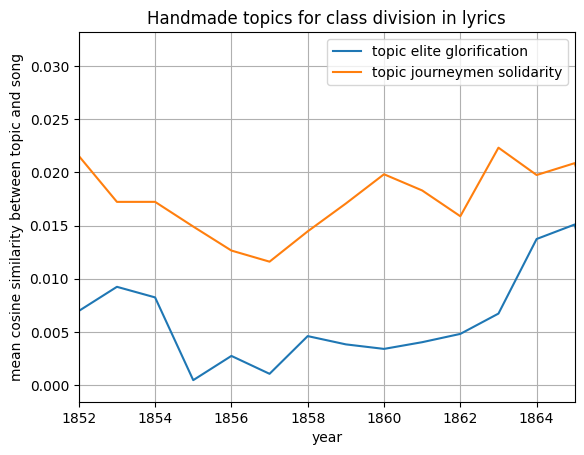

In [12]:
# Glorification of the elite vs the solidarity among printworkers
ax = df['topic2'].plot(title="Handmade topics for class division in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic4'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['topic elite glorification', 'topic journeymen solidarity'])


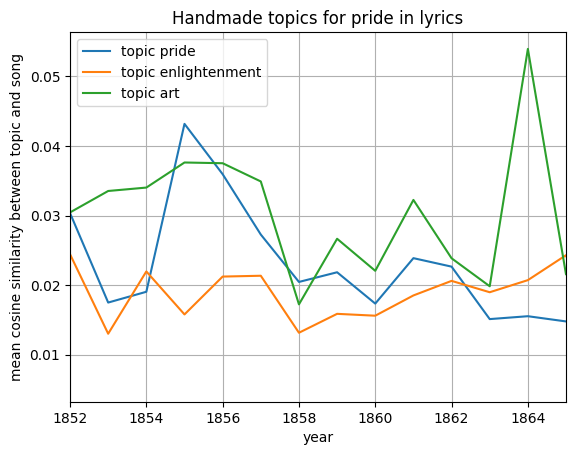

In [20]:
# Professional pride and honour
ax = df['topic7'].plot(title="Handmade topics for pride in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic6'].plot(grid=True)
ax = df['topic5'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['topic pride', 'topic enlightenment', 'topic art'])

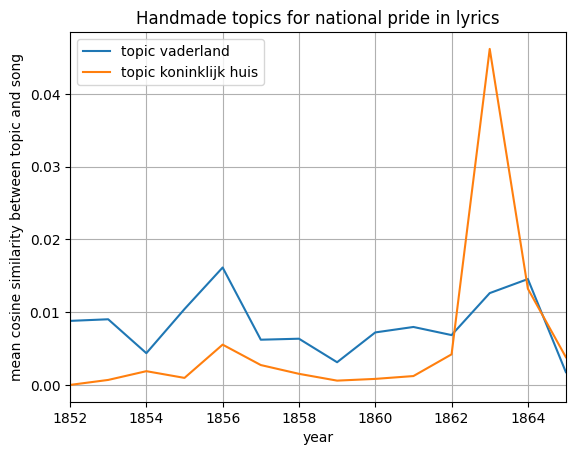

In [14]:
# Professional pride and honour
ax = df['topic0'].plot(title="Handmade topics for national pride in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic1'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['topic vaderland', 'topic koninklijk huis'])

In [15]:
topic0 = topic0 + topic1
topic1 = topic3
topic2 = topic6 + topic7

topicListTotal = [topic0, topic1, topic2]
topicVectorsTotal = np.array(topics2vectors(topicListTotal, liedjesVocabulary))

df = createSimilarities(topicVectorsTotal, liedjesDF)

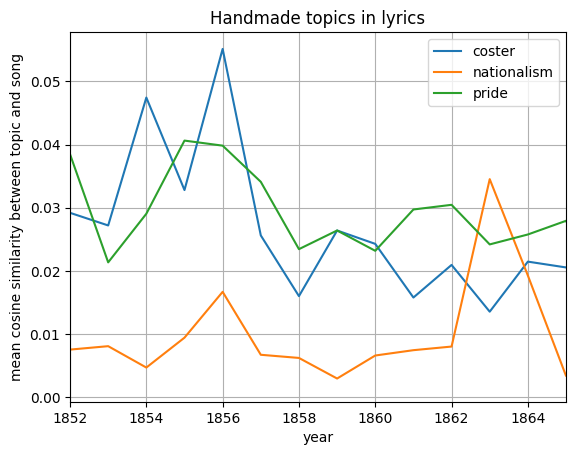

In [16]:
# Total figure
ax = df['topic1'].plot(title="Handmade topics in lyrics", xlim=(1852,1865), grid=True)
ax = df['topic0'].plot(grid=True)
ax = df['topic2'].plot(grid=True)
ax.set_ylabel('mean cosine similarity between topic and song')
ax.set_xlabel('year')
ax.legend(['coster', 'nationalism', 'pride'])